In [ ]:
#@title Install prerequsite

!pip install biopython
!pip install weblogo

# install ghostscript for weblogo
!apt-get update
!apt-get install ghostscript

In [ ]:
#@title Mount Google Drive (You don't need to run this if you are running notebooks on your laptop)

from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set data file location
# If you are running notebooks on your laptop, change this to the directory
# where you put downloaded files

from pathlib import Path

DATA = Path("")

## Simplified cancer mutation model



We defined a simple cancer mutation model by the following rules:

* A particular cell becomes diseased by this cancer if and only if $N$ particular kinds of mutations occur in its genome
* Each of these $N$ mutations has equal probability $p$ to occur in any cell within a time period of one year
* $M$ cells of the body are susceptible to this kind of cancer 
* The mutations in each of these cells occur independently of the mutations that may have already occurred
* This cancer will occur if and only if at least one out of the $M$ cells becomes malignant by undergoing all $N$ kinds of mutations

With one mutation, after $t$ years go by, the probability of the mutation has NOT occur is 
$$(1 - p)^t$$
Therefore, sometime during $t$ years, the probability of having this mutation is
$$ 1 - (1 - p)^t$$

To cause cancer the cell must have all $N$ mutations, therefore, the probability of having all $N$ mutations during any time of first $t$ years is
$$Q(p, t, N) = (1 - (1 - p)^t)^N$$

Assume there is $M$ such cells in human body, if any of them undergo the process of acquiring all mutations cancer would occur. The probability of having _NONE_ of the cells undergo such process would be
$$\big(1 - Q(p, t, N)\big)^M$$

Therefore, the probability having cancer anytime during the first $t$ years would be
$$R(p, t, N, M) = 1 - \big(1 - Q(p, t, N)\big)^M = 1 - \big(1 - (1 - (1 - p)^t)^N\big)^M$$

Given fixed number of cells, mutations, and probability of mutation, the probability of being diagnosed of cancer at age $T$ would be
$$ P(\text{cancer at T} | \text{no cancer at} (T-1)) = \frac{R(T) - R(T-1)}{1 - R(T-1)}$$

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def mutation_prob_at_time(t, p):
    return 1 - (1 - p) ** t

def all_mutation_prob_at_time(t, p, N):
    return (mutation_prob_at_time(t, p)) ** N

def cancer_cell_prob_at_time(t, p, N, M):
    return 1 - (1 - all_mutation_prob_at_time(t, p, N))**M

We can visualize the mutation probability as follows

In [ ]:
# mutation probability: 0.1
p = 0.1
# time: 0 to 99 years
t = np.arange(100)
# 6 mutations
N = 6
# 100 cells
M = 100

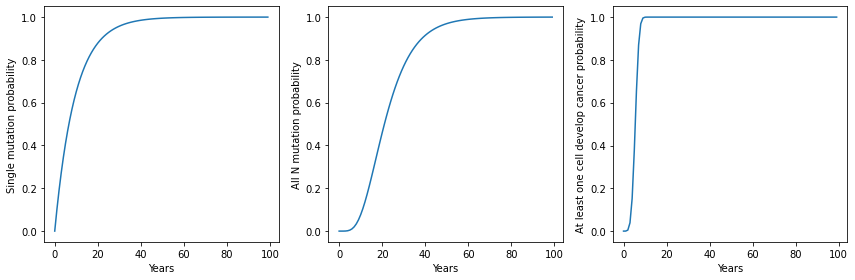

In [ ]:
fig, axarr = plt.subplots(1, 3)
fig.set_size_inches(12, 4)
axarr[0].plot(t, mutation_prob_at_time(t, p));
axarr[0].set_xlabel("Years");
axarr[0].set_ylabel("Single mutation probability");

axarr[1].plot(t, all_mutation_prob_at_time(t, p, N));
axarr[1].set_xlabel("Years");
axarr[1].set_ylabel("All N mutation probability");

axarr[2].plot(t, cancer_cell_prob_at_time(t, p, N, M));
axarr[2].set_xlabel("Years");
axarr[2].set_ylabel("At least one cell develop cancer probability");

plt.tight_layout()

Now let's define the probability of getting cancer at age $T$ and use a more realistic number

In [ ]:
# mutation probability: 0.0005
p = 5e-4
# time: 0 to 99 years
t = np.arange(100)
# 6 mutations
N = 6
# 1.6 trillion cell type
M = 1.6e12

In [ ]:
def cancer_prob_at_age(t, p, N, M):
    return ((cancer_cell_prob_at_time(t+1, p, N, M) - cancer_cell_prob_at_time(t, p, N, M)) / 
            (1 - cancer_cell_prob_at_time(t, p, N, M)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


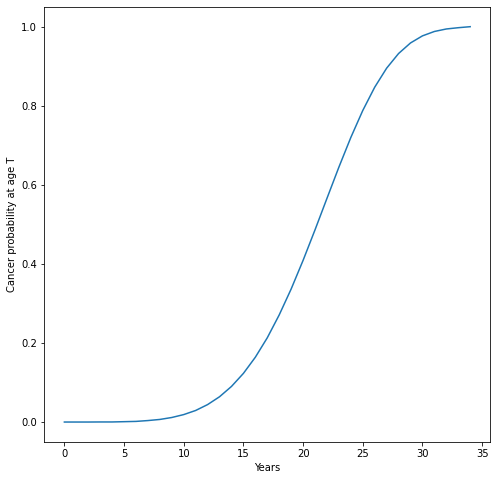

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax.plot(t, cancer_prob_at_age(t, p, N, M));
ax.set_xlabel("Years");
ax.set_ylabel("Cancer probability at age T");


The above shows the probability of having cancer at age $T$. We can translate this to __population cancer risk__ at age $T$ of any type of cancer. However, note this model is extremely simplified. To read more about mutation rate and cancer risk, [a recent paper](http://science.sciencemag.org/content/355/6331/1330) and [an article](https://www.scientificamerican.com/article/most-cancer-cases-arise-from-bad-luck/ ) discussing this paper is a very good read.

## Analyzing outcome of mutation calling pipeline: `MAF` files



Mutation Annotation Format (MAF) files are the output from somatic mutation calling pipelines. Each somatic mutation was called comparing the variant between two the tumor sample and the adjecent normal sample. The format of MAF is much simpler and it's usually much smaller than VCFs. 

Here we will load the mutations from 1,044 breast cancer patients from [The Cancer Genome Atlas](https://cancergenome.nih.gov/), or TCGA. It is a tremendous resource for cancer research. The interface for downloading its data is through the [NCI Genomic Data Commons Data Portal](https://portal.gdc.cancer.gov/), or GDC. 


In [ ]:
# change the filename parameter to where you download the maf.gz file
maf_file = "TCGA.BRCA.mutect.995c0111-d90b-4140-bee7-3845436c3b42.DR-10.0.somatic.maf.gz"

Since the format is relatively simple and file is small, we can directly load it into a `pandas.DataFrame`, skipping any lines starts with `#`.

In [ ]:
import pandas as pd

pd.set_option('display.max_columns', None)

In [ ]:
maf = pd.read_csv(DATA / maf_file, sep="\t", comment='#')

maf.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (87,88,118) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_File,Sequencer,Tumor_Sample_UUID,Matched_Norm_Sample_UUID,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,Exon_Number,t_depth,t_ref_count,t_alt_count,n_depth,n_ref_count,n_alt_count,all_effects,Allele,Gene,Feature,Feature_type,One_Consequence,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,TRANSCRIPT_STRAND,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,RefSeq,SIFT,PolyPhen,EXON,INTRON,DOMAINS,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EAS_MAF,EUR_MAF,SAS_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,IMPACT,PICK,VARIANT_CLASS,TSL,HGVS_OFFSET,PHENO,MINIMISED,ExAC_AF,ExAC_AF_Adj,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,GENE_PHENO,FILTER,CONTEXT,src_vcf_id,tumor_bam_uuid,normal_bam_uuid,case_id,GDC_FILTER,COSMIC,MC3_Overlap,GDC_Validation_Status
0,USP24,23358,WUGSC,GRCh38,chr1,55159655,55159655,+,Missense_Mutation,SNP,T,T,C,rs150880897,by1000G;byCluster;byFrequency,TCGA-D8-A1XY-01A-11D-A14K-09,TCGA-D8-A1XY-10A-01D-A14K-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,edb6d161-8f50-4c11-8246-487c4ea9a55d,8dea96d9-5017-4872-a84e-33bfd2f37b7a,c.1024A>G,p.Ile342Val,p.I342V,ENST00000294383,9/68,82,49,33,126,NaN,NaN,"USP24,missense_variant,p.I342V,ENST00000294383...",C,ENSG00000162402,ENST00000294383,Transcript,missense_variant,missense_variant,1024/10549,1024/7863,342/2620,I/V,Atc/Gtc,rs150880897,1,NaN,-1.0,USP24,HGNC,HGNC:12623,protein_coding,YES,CCDS44154.2,ENSP00000294383,Q9UPU5,NaN,UPI000059CFDE,NM_015306.2,tolerated(0.37),benign(0.003),9/68,NaN,NaN,0.0020,0.0076,0.0,NaN,0.0,0.0,0.0,0.0059,0.0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MODERATE,1.0,SNV,5.0,NaN,NaN,1,0.000715,0.002251,0.009470,0.0,0.0,0.0,0.002752,0.003676,0.0,NaN,panel_of_normals,CTGGATTGTAG,d083d669-6646-463b-853e-c58da8d06439,4374e19d-c5e7-49cf-8707-05ae5aeb7369,aadee87c-6a68-4580-bd10-64ac273b1e3d,0130d616-885e-4a6c-9d03-2f17dd692a05,common_in_exac;gdc_pon,NaN,True,Unknown
1,ERICH3,127254,WUGSC,GRCh38,chr1,74571494,74571494,+,Missense_Mutation,SNP,C,C,T,NaN,NaN,TCGA-D8-A1XY-01A-11D-A14K-09,TCGA-D8-A1XY-10A-01D-A14K-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,edb6d161-8f50-4c11-8246-487c4ea9a55d,8dea96d9-5017-4872-a84e-33bfd2f37b7a,c.4216G>A,p.Glu1406Lys,p.E1406K,ENST00000326665,14/15,86,42,44,64,NaN,NaN,"ERICH3,missense_variant,p.E1406K,ENST000003266...",T,ENSG00000178965,ENST00000326665,Transcript,missense_variant,missense_variant,4435/7159,4216/4593,1406/1530,E/K,Gag/Aag,NaN,1,NaN,-1.0,ERICH3,HGNC,HGNC:25346,protein_coding,YES,CCDS30755.1,ENSP00000322609,Q5RHP9,NaN,UPI0000237200,NM_001002912.4,deleterious(0.01),possibly_damaging(0.833),14/15,NaN,PROSITE_profiles:PS50313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MODERATE,1.0,SNV,5.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,TTCCTCTACCA,d083d669-6646-463b-853e-c58da8d06439,4374e19d-c5e7-49cf-8707-05ae5aeb7369,aadee87c-6a68-4580-bd10-64ac273b1e3d,0130d616-885e-4a6c-9d03-2f17dd692a05,NaN,COSM1474194,True,Unknown
2,KIF26B,55083,WUGSC,GRCh38,chr1,245419680,245419680,+,Silent,SNP,G,G,T,NaN,NaN,TCGA-D8-A1XY-01A-11D-A14K-09,TCGA-D8-A1XY-10A-01D-A14K-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,edb6d161-8f50-4c11-8246-487c4ea9a55d,8dea96d9-5017-4872-a84e-33bfd2f37b7a,c.1101G>T,p.=,p.S367S,ENST00000407071,

As you can see, the `mutect` tool used in the mutation calling pipeline already has annotation to it. We will first filter the table by keeping only variants pass the different filter criteria (`FILTER = PASS`) and also medium to high impact variants (`IMPACT = MODERATE or IMPACT = HIGH`).

For more information about each column in MAF files, see [this page](https://software.broadinstitute.org/software/igv/MutationAnnotationFormat) from Broad Institute.

In [ ]:
mut = maf[(maf.FILTER == "PASS") & ((maf.IMPACT == "MODERATE") | (maf.IMPACT == "HIGH"))]

print("{} out of {} mutations passed the filtering criteria, {:.2f}%".format(
    len(mut), len(maf), 100 * len(mut) / len(maf)))

73156 out of 120988 mutations passed the filtering criteria, 60.47%


Let's do a simple statistics on finding what is the most mutated genes in breast cancer. We simply group the mutations by genes and count unique samples it contains.

In [ ]:
mut.Tumor_Sample_Barcode.nunique()

985

In [ ]:
mutation_frequency = mut.groupby("Hugo_Symbol")["Tumor_Sample_Barcode"].nunique().reset_index()

mutation_frequency.sort_values("Tumor_Sample_Barcode", ascending=False, inplace=True)

mutation_frequency.head(10)

,Hugo_Symbol,Tumor_Sample_Barcode
14207,TP53,325
10175,PIK3CA,323
14595,TTN,184
2338,CDH1,132
5145,GATA3,129
8415,MUC16,111
7076,KMT2C,90
7760,MAP3K1,79
11836,RYR2,63
5967,HMCN1,61


If you search for the top two genes `PIK3CA`, `TP53` together by name only, you will see they are known to be connected to breast cancer. Interestingly, `TTN` is also one of the top mutated genes. However one actually would need to take into account that `TTN` is one of the longest gene in human genome. It might account to some degree the reason why it's so frequently mutated.



More advanced analysis involved summarizing mutations based on gene pathways or biological functions. This will be in one of our homeworks.

## Probabilistic model of DNA sequences



We describe two simple probabilistic models that can be used for some of these patterns. The first model is based on the relative frequencies of the occurrence of "words" (multiple consecutive DNA nucleotides). 

### Compositional analysis
To use the first type of probabilistic models, we perform compositional analysis measuring the relative frequencies of all "k-letter words" (also called "k-tuples") of consecutive nucleotides that appear in the sequence, including words that overlap with each other. For example, the sequence `5'-AGATTTA-3'` contains three (overlapping) 5-letter words: `'AGATT'`, `'GATTT'` and `'ATTTA'` in its 5' to 3' direction. In a sufficiently long sample of totally random DNA, all 4$^k$ possible words for a given value of `k` will appear with approximately equal relative frequency 1/4$^k$. Any significant deviation from this rule would qualify as a "pattern".

### Simplest example of DNA composition analysis

In this example we will explore the DNA sequence of the human mitochondria. Mitochondria are semi autonomous structures, called organelles, that are found in the cytoplasm of the cells hundreds to thousands in most of the eukaryotic organisms. They have an important role of producing ATP, which is the energy currency of the cells, and regulate cell metabolism. Mitochondria has its own DNA that is distinct from its "host": a much shorter, ~ 16,500 bp chromosome. It's annotated in human reference geome as `ChrM`.

In [ ]:
from Bio import SeqIO
import gzip
from collections import OrderedDict
import pandas as pd
import numpy as np

from Bio import Entrez
from Bio import SeqIO
import os

# modified from: https://gist.github.com/avrilcoghlan/6308594
def getgenbank(seq_id):
    filename = "{}_fasta".format(seq_id)
    if not os.path.isfile(filename):
        print("Downloading {}...".format(filename))
        handle = Entrez.efetch(db="nucleotide", id=seq_id, rettype="fasta")
        output = open(filename, "w")
        output.write(handle.read())
        output.close()
        print("Saved {}".format(filename))
    print("Parsing filename {}...".format(filename))
    record = SeqIO.read(open(filename),"fasta")
    return record

In [ ]:
# mitochondria access number is 'NC_012920'
seq_id = "NC_012920"
chrM_record = getgenbank(seq_id)
chrM = str(chrM_record.seq)
s = chrM
len(s)

Parsing filename NC_012920_fasta...


16569

In [ ]:
s[:100]

'GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCATGCATTTGGTATTTTCGTCTGGGGGGTATGCACGCGATAGCATTGCGAGACGCTG'

For `k=1`, we have the simplest test of DNA composition analysis, i.e., measuring the relative frequencies of each of the four single nucleotides (__"mononucleotides"__), which would be about 25% for each, in the absence of any bias that would favor one type of nucleotide over another.

In [ ]:
def count_nucleotide(window):
    return OrderedDict((nt, window.count(nt)) for nt in {'A', 'G', 'T', 'C'})

The `count_nucleotide` function accepts a window of nucleotides and returns the number of each nucleotide in them.

In [ ]:
window_size = 1000
nt_counts = pd.DataFrame.from_records(
    [count_nucleotide(s[i:(i + window_size)]) for i in range(len(s) - window_size+1)])
# reorder columns
nt_counts = nt_counts[['A', 'G', 'T', 'C']]
nt_density = nt_counts / window_size

We will make the `count_nucleotide` function more general by adding another parameter, `k`, to calculate the occurrence of k-letter words.

In [ ]:
import itertools
import re
def count_tuples(window, k):
    return OrderedDict(
        (''.join(tp), len(re.findall("(?={})".format(''.join(tp)), window)))
         for tp in itertools.product(['A', 'G', 'T', 'C'], repeat=k)
    )

In [ ]:
window_size = 1000
k = 1
# count frequency of mononucleotides
mnt_counts = pd.DataFrame.from_records(
    [count_tuples(s[i:(i + window_size)], k) for i in range(len(s) - window_size + 1)])
mnt_density = mnt_counts / window_size

In [ ]:
mnt_counts.head()

,A,G,T,C
0,311,146,233,310
1,311,145,233,311
2,310,145,233,312
3,311,145,232,312
4,311,146,232,311


We can visualize the density change along the sequence by plotting them:

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

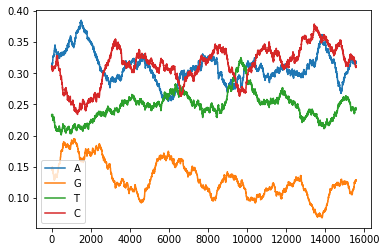

In [ ]:
mnt_density.plot()

For `k = 2`, there are 4$^2$ = 16 __dinucleotides__ (ordered pairs of nucleotides). In totally random DNA, each of them would appear with approximate relative frequency of `1/16 = 6.25%`. One of the most well-known and common deviations from that rule occurs exclusively for the CG dinucleotide (in the 5' to 3' direction) in genomic regions of vertebrates. This dinucleotide is referred to as `"CpG"`, where `p` stands for the "phosphodiester" covalent bond connecting the two nucleotides, to distinguish from the `CG` pair of complementary bases, which are connected by a hydrogen bond. For example, the `CpG` frequency of the human genome is much lower than the expected average in totally random DNA (consistently, recall the transition matrix in the `biomarkov` function). The other 15 dinucleotides are in relatively normal proportions. The reason for this fact is a specific mutational bias related to a chemical modification that reduces the chance of a `C` to survive without being mutated when it is positioned at the 5' end of a `G`. However, an exception to this reduction of `CpG` dinucleotides occurs in many DNA stretches about a few hundred to a few thousand base pairs long, lying around the regulatory regions of many human genes. The `CpG` frequencies in those so-called __"CpG islands"__ are not reduced. The presence of `CpG` islands is related to a nucleotide modification, called __methylation__, which may influence gene expression. There are approximately 45,000 such `CpG` islands in the human genome.

In [ ]:
window_size = 1000
k = 2
# count frequency of dinucleotides
dnt_counts = pd.DataFrame.from_records(
    [count_tuples(s[i:(i + window_size)], k) for i in range(len(s) - window_size + 1)])
dnt_density = dnt_counts / window_size

In [ ]:
dnt_counts.head()

,AA,AG,AT,AC,GA,GG,GT,GC,TA,TG,TT,TC,CA,CG,CT,CC
0,102,53,65,91,30,28,36,52,71,35,70,56,108,29,62,111
1,102,53,65,91,29,28,36,52,71,35,70,57,108,29,62,111
2,102,53,64,91,29,28,36,52,71,35,70,57,108,29,62,112
3,102,53,64,91,29,28,36,52,71,35,70,56,109,29,62,112
4,102,54,64,91,29,28,36,52,71,35,70,56,108,29,62,112


In [ ]:
dnt_density.head()

,AA,AG,AT,AC,GA,GG,GT,GC,TA,TG,TT,TC,CA,CG,CT,CC
0,0.102,0.053,0.065,0.091,0.030,0.028,0.036,0.052,0.071,0.035,0.07,0.056,0.108,0.029,0.062,0.111
1,0.102,0.053,0.065,0.091,0.029,0.028,0.036,0.052,0.071,0.035,0.07,0.057,0.108,0.029,0.062,0.111
2,0.102,0.053,0.064,0.091,0.029,0.028,0.036,0.052,0.071,0.035,0.07,0.057,0.108,0.029,0.062,0.112
3,0.102,0.053,0.064,0.091,0.029,0.028,0.036,0.052,0.071,0.035,0.07,0.056,0.109,0.029,0.062,0.112
4,0.102,0.054,0.064,0.091,0.029,0.028,0.036,0.052,0.071,0.035,0.07,0.056,0.108,0.029,0.062,0.112


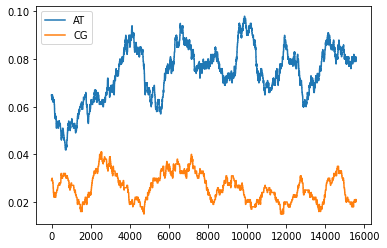

In [ ]:
dnt_density[['AT', 'CG']].plot()

For `k = 3`, there are 4$^3$ = 64 __trinucleotides__ (ordered triplets of nucleotides). In totally random DNA, each of them would appear with approximate relative frequency `1/64 = 1.56%`. For the protein-coding regions in DNA, the term "codon usage bias" is used to refer to deviations from this average frequency among the codons. Codon usage bias may be related to the higher frequency of some amino acids in certain proteins. However, biases often exist even in the usage among several "synonymous" codons, i.e., coding the same amino acid. Such codon usage biases are often quite distinct for different species and the reasons for these biases are not always clear.

In [ ]:
k = 3
# count frequency of dinucleotides
tnt_counts = pd.DataFrame.from_records(
    [count_tuples(s, k)])

Note we did not use a moving window for the sequence due to simplicity, but just count all occurrence of the triplets in the genome.

In [ ]:
tnt_counts.head()

,AAA,AAG,AAT,AAC,AGA,AGG,AGT,AGC,ATA,ATG,ATT,ATC,ACA,ACG,ACT,ACC,GAA,GAG,GAT,GAC,GGA,GGG,GGT,GGC,GTA,GTG,GTT,GTC,GCA,GCG,GCT,GCC,TAA,TAG,TAT,TAC,TGA,TGG,TGT,TGC,TTA,TTG,TTT,TTC,TCA,TCG,TCT,TCC,CAA,CAG,CAT,CAC,CGA,CGG,CGT,CGC,CTA,CTG,CTT,CTC,CCA,CCG,CCT,CCC
0,524,209,376,495,178,174,161,282,367,162,330,371,448,119,412,515,201,129,114,169,122,72,80,151,154,55,104,106,207,54,179,271,414,258,324,377,190,99,100,123,329,116,251,308,415,121,307,361,465,199,416,454,122,80,78,155,523,180,318,419,464,141,542,624


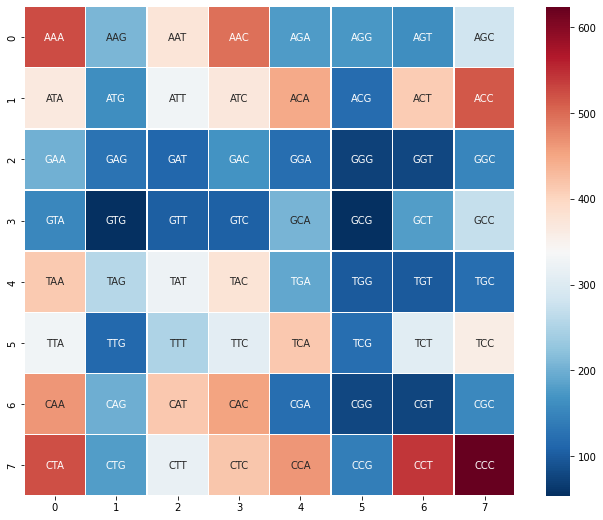

In [ ]:
cols = tnt_counts.columns
tnt_counts_heat_map = tnt_counts.values.reshape(8,-1)
labels = np.array(cols, cols).reshape(8,-1)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(tnt_counts_heat_map, cmap="RdBu_r",annot=labels, fmt='', linewidths=0.5)